In [124]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from models.resnet_clothing_model import ClothingClassifier
from data.dataset import  TrainGarmentDataset
from data.transformation import CustomResNetTransform
from data.category_manager import CategoryManager

In [125]:
# Load model
num_topwear_classes = 20
num_bottomwear_classes = 16
num_both_classes = 14

model = ClothingClassifier( num_topwear_classes=num_topwear_classes,
                            num_bottomwear_classes=num_bottomwear_classes, 
                            num_both_classes=num_both_classes)
model.load_state_dict(torch.load('clothing_classifier.pth'))
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ClothingClassifier(
  (resnet_backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

In [126]:
# Load dataset and dataloader
batch_size = 1
train_dataset = TrainGarmentDataset(transform=CustomResNetTransform())
dataLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
categoryManager = CategoryManager()

# Get a batch of data
batch = next(iter(dataLoader))
image = batch[0].to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.64].


Predictions:
  Topwear Presence: 1.00
  Topwear Category: 17
  Topwear Item: Tee
  Bottomwear Presence: 1.00
  Bottomwear Category: 11
  Bottomwear Item: Shorts
  Both Presence: 1.00
  Both Category: 4
  Both Item: Dress


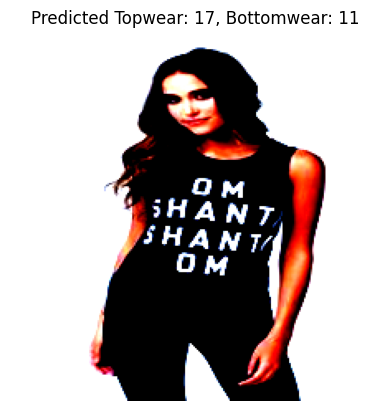

In [127]:
# Run inference
with torch.no_grad():
    outputs = model(image)

topwear_p, bottomwear_p, both_p, topwear_c, bottomwear_c, both_c = outputs

# Process outputs
topwear_presence = topwear_p
bottomwear_presence = bottomwear_p
both_presence = both_p

topwear_category = torch.argmax(F.softmax(topwear_c, dim=1), dim=1)
bottomwear_category = torch.argmax(F.softmax(bottomwear_c, dim=1), dim=1)
both_category = torch.argmax(F.softmax(both_c, dim=1), dim=1)

# Print predictions
print("Predictions:")
print(f"  Topwear Presence: {topwear_presence.item():.2f}")
print(f"  Topwear Category: {topwear_category.item()}")
print(f"  Topwear Item: {categoryManager.get_category_name(topwear_category=topwear_category.item())}")

print(f"  Bottomwear Presence: {bottomwear_presence.item():.2f}")
print(f"  Bottomwear Category: {bottomwear_category.item()}")
print(f"  Bottomwear Item: {categoryManager.get_category_name(bottomwear_category=bottomwear_category.item())}")

print(f"  Both Presence: {both_presence.item():.2f}")
print(f"  Both Category: {both_category.item()}")
print(f"  Both Item: {categoryManager.get_category_name(both_category=both_category.item())}")

# Display the image
image_np = image.squeeze(0).cpu().permute(1, 2, 0).numpy()  # Convert from (1, C, H, W) -> (H, W, C)
plt.imshow(image_np)
plt.axis("off")
plt.title(f"Predicted Topwear: {topwear_category.item()}, Bottomwear: {bottomwear_category.item()}")
plt.show()